In [14]:
import pandas as pd
import numpy as np

# Load the dataset from CSV
df = pd.read_csv('aim_data.csv')
df.head()

,class,rotation_dyaw,rotation_dpitch,rotation_ddyaw,rotation_ddpitch,intercept_x,intercept_y,center_angle_offset,t_min_x,t_min_y,t_min_z,t_max_x,t_max_y,t_max_z
0,human,-4.651917,-0.433859,7.616699,-0.602583,0.579518,0.376411,-351.461426,1715.3500,181.900000,588.19375,1716.150000,183.90000,588.993750
1,human,0.192871,0.000000,4.844788,0.433859,0.512843,0.453826,-355.809753,1715.0375,181.900000,587.94375,1716.150000,184.24375,588.993750
2,human,2.073303,0.024103,1.880432,0.024103,0.487868,0.462319,-357.084290,1715.0375,182.014583,587.94375,1716.045833,184.24375,588.910417
3,human,3.880554,0.723099,1.807251,0.698996,0.491646,0.479815,-357.079285,1715.0375,182.129167,587.94375,1715.941667,184.24375,588.827083
4,human,4.964966,0.891823,1.084412,0.168725,0.533719,0.481217,-356.387085,1715.0375,182.025000,587.94375,1715.837500,184.24375,588.743750


In [2]:
# For our case, we don't need angle offset or target position profile.
# We are primarily focused with using rotational and tracking data for aimbot detection.
df = df.iloc[:, :7]
df.head()

,class,rotation_dyaw,rotation_dpitch,rotation_ddyaw,rotation_ddpitch,intercept_x,intercept_y
0,human,-4.651917,-0.433859,7.616699,-0.602583,0.579518,0.376411
1,human,0.192871,0.000000,4.844788,0.433859,0.512843,0.453826
2,human,2.073303,0.024103,1.880432,0.024103,0.487868,0.462319
3,human,3.880554,0.723099,1.807251,0.698996,0.491646,0.479815
4,human,4.964966,0.891823,1.084412,0.168725,0.533719,0.481217


In [3]:
from scipy.stats import iqr
from statsmodels import robust

# 50 samples strikes a great balance for our dataset size. Small enough to capture micro patterns, large enough to avoid overfitting & high variance.
# This is equal to 2.5 seconds of data in Minecraft. (20 ticks per second)
WINDOW_SIZE = 50

feature_columns = [col for col in df.columns if col != 'class']

windows_data = []
labels = []

for start in range(0, len(df) - WINDOW_SIZE + 1, WINDOW_SIZE):
    end = start + WINDOW_SIZE

    window_df = df.iloc[start:end]

    # Check if all labels in window are the same
    # There are many ways to handle windows with non-unique labels, though for simplicity in this prototype we will just skip any that appear.
    cohesive = window_df['class'].nunique() == 1
    if not cohesive:
        continue

    # Prepare dictionary for this window
    stats_dict = {}

    # We extract a variety of statistical features to give as much information from the raw data for the model to work with.
    # We are compressing multi-variate time series data into a rough representation by statistical features essentially.
    # It is important to have a variety of statistics with a wide range of meaning to prevent overfitting and underperformance.
    for col in feature_columns:
        series = window_df[col]
    
        stats_dict[f"{col}_mean"] = series.mean()
        stats_dict[f"{col}_std"] = series.std()
        stats_dict[f"{col}_median"] = series.median()
        stats_dict[f"{col}_iqr"] = iqr(series)
        stats_dict[f"{col}_mad"] = robust.mad(series)
        stats_dict[f"{col}_min"] = series.min()
        stats_dict[f"{col}_max"] = series.max()
        stats_dict[f"{col}_range"] = series.max() - series.min()
        stats_dict[f"{col}_abs_mean"] = series.abs().mean()

    # Attach the label to the window.
    stats_dict['class'] = window_df['class'].iloc[0]

    windows_data.append(stats_dict)

# Create DataFrame
stats_df = pd.DataFrame(windows_data)

In [4]:
stats_df.head()

,rotation_dyaw_mean,rotation_dyaw_std,rotation_dyaw_median,rotation_dyaw_iqr,rotation_dyaw_mad,rotation_dyaw_min,rotation_dyaw_max,rotation_dyaw_range,rotation_dyaw_abs_mean,rotation_dpitch_mean,...,intercept_y_mean,intercept_y_std,intercept_y_median,intercept_y_iqr,intercept_y_mad,intercept_y_min,intercept_y_max,intercept_y_range,intercept_y_abs_mean,class
0,-2.070479,4.723414,0.000000,6.254822,4.824565,-11.690186,4.964966,16.655151,3.664229,-0.044832,...,0.373716,0.179360,0.379545,0.214491,0.167215,0.046154,0.702702,0.656547,0.373716,human
1,-1.598025,4.649437,-1.084808,6.923401,5.271273,-10.268005,6.797180,17.065186,3.944734,-0.175955,...,0.521644,0.273240,0.526846,0.360579,0.250857,0.070056,1.167153,1.097097,0.521644,human
2,-0.273353,4.329928,-0.819672,3.296402,2.448140,-5.760437,19.138000,24.898438,2.787853,0.305631,...,0.390896,0.142321,0.350358,0.201372,0.144317,0.201652,0.760776,0.559124,0.390896,human
3,-0.637780,5.071724,-0.301361,7.007935,5.342264,-15.040405,7.664917,22.705322,4.039254,-0.437236,...,0.492393,0.232186,0.498804,0.238219,0.198713,-0.069169,0.922378,0.991547,0.495939,human
4,0.573712,3.717674,0.928040,4.218521,3.698995,-11.063477,8.532593,19.596069,2.931996,0.044351,...,0.450933,0.208999,0.556024,0.270521,0.136050,-0.103750,0.752253,0.856002,0.458744,human


In [5]:
from sklearn.preprocessing import StandardScaler

# As is standard, we apply standard scaling. This ensures features contribute somewhat equally, improves convergence speed, and helps with noise issues.
# Also, it improves consistency between test predictions and live environment predictions.
scaler = StandardScaler()

# Since this is a binary classification task and we have 4 classes in the dataset, we need the classes to differentiate human vs. aimbot.
stats_df['binary_class'] = (stats_df['class'] == 'human').astype(int)

X_df = stats_df.drop(columns=['class','binary_class'])

# We add some artificial noise. Noise helps reduce overfitting and improves generalization by increasing randomness in the data set.
# Noise helps the model generalize on macro patterns instead of overfitting on microscopic patterns.
# Although, the compression to statistical metrics kind of smooths everything out for us already.
X_df = X_df + np.random.normal(0, 0.05, X_df.shape)

# Apply the scaling
X_df = scaler.fit_transform(X_df)

# These are our labels
y_series = stats_df['binary_class']

# Here we convert back to a DataFrame because we want to visualize feature importance with labels later.
feature_columns = [col for col in stats_dict if col != "class" and col != "binary_class"]
X_df = pd.DataFrame(X_df, columns=feature_columns)

X_df.head()

,rotation_dyaw_mean,rotation_dyaw_std,rotation_dyaw_median,rotation_dyaw_iqr,rotation_dyaw_mad,rotation_dyaw_min,rotation_dyaw_max,rotation_dyaw_range,rotation_dyaw_abs_mean,rotation_dpitch_mean,...,intercept_x_abs_mean,intercept_y_mean,intercept_y_std,intercept_y_median,intercept_y_iqr,intercept_y_mad,intercept_y_min,intercept_y_max,intercept_y_range,intercept_y_abs_mean
0,-1.935956,0.254771,-0.034319,0.743818,0.879312,-0.178423,-0.664702,-0.196685,0.371063,-0.047832,...,-0.254657,0.155732,0.883582,-0.262952,0.379185,-0.096686,-0.106680,-0.048153,0.268768,-0.095953
1,-1.458831,0.260622,-1.208653,1.071367,1.079226,-0.018404,-0.361457,-0.158219,0.727369,-0.097961,...,0.727616,0.813227,0.665776,0.947711,1.804662,1.366888,-0.014610,2.340592,2.305023,1.286899
2,-0.241453,0.073482,-0.914445,-0.651338,-0.660578,0.484044,1.654395,0.463818,-0.244032,0.552165,...,-0.276677,-0.594589,-0.330881,0.574929,0.786229,0.143043,0.799561,0.747072,-0.177326,-0.238466
3,-0.564285,0.424670,-0.487895,1.041433,1.102761,-0.565965,-0.229133,0.287649,0.714955,-0.969822,...,-0.267581,1.221181,0.081754,1.167659,1.171248,1.204920,-0.856647,1.215976,1.596716,0.937312
4,0.553274,-0.197177,1.096738,-0.206694,0.125934,-0.110310,-0.091803,0.040719,-0.182961,0.225906,...,-0.447469,1.120193,1.498888,1.323126,1.102426,0.137821,-0.985584,0.989599,0.863253,0.814808


In [6]:
from sklearn.model_selection import train_test_split

# Create the train test split.
# Stratify removes class imbalance (critical for binary classification tasks). Otherwise, the model may learn that predicting one class minimizes loss.
# Random state is used to ensure consistency during testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    y_series,
    test_size = 0.2,
    random_state=42,
    stratify=y_series
)

In [7]:
import xgboost as xgb

# Here is our model. As you can see there are lots of parameters.
# Our objective is logistic regression to output class probability between 0 and 1.
# We minimize cross entropy loss, this is pretty standard for binary classification task.
# Limiting max_depth ensures model does not overfit by reducing depth of decision trees.
# Learning rate is a tradeoff, you need a fine balance between speed and not overshooting minima in the loss gradient.
# Estimators = trees, we have 100 decision trees.
# L2 regularization helps reduce overfitting by reducing leaf weights on our decision trees. This prevents a few leaves from being too dominant in the classification.
classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    max_depth=5,
    learning_rate = 0.05,
    n_estimators = 50,
    reg_alpha=1.0,
    reg_lambda=2.0
)

classifier.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Run the classification on the test set
y_pred = classifier.predict(X_test)

# You can see we have a pretty good F1-score here. But we need to really test in a live environment to know if this model is actually good, or if we are just overfitting on the dataset.
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[42  0]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.96      0.98        24

    accuracy                           0.98        66
   macro avg       0.99      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



In [9]:
from sklearn.model_selection import cross_val_score

# Here we run some cross validation to ensure consistency between multiple train/test splits. What if we just got lucky on our split?
# This is especially important because our dataset is super small, since this is a prototype project.
scores = cross_val_score(
    classifier,
    X_df,
    y_series,
    cv=10,
    scoring='accuracy'
)

# On 10 different cross validation folds, we got pretty good accuracy!
print(f'Lowest accuracy: {(scores.min() * 100):.4f}%')
print(f'Highest accuracy: {(scores.max() * 100):.4f}%')
print(f'Mean accuracy: {(scores.mean() * 100):.4f}%')
print(f'Standard deviation: {(scores.std() * 100):.4f}%')

Lowest accuracy: 87.8788%
Highest accuracy: 100.0000%
Mean accuracy: 97.8788%
Standard deviation: 3.5983%


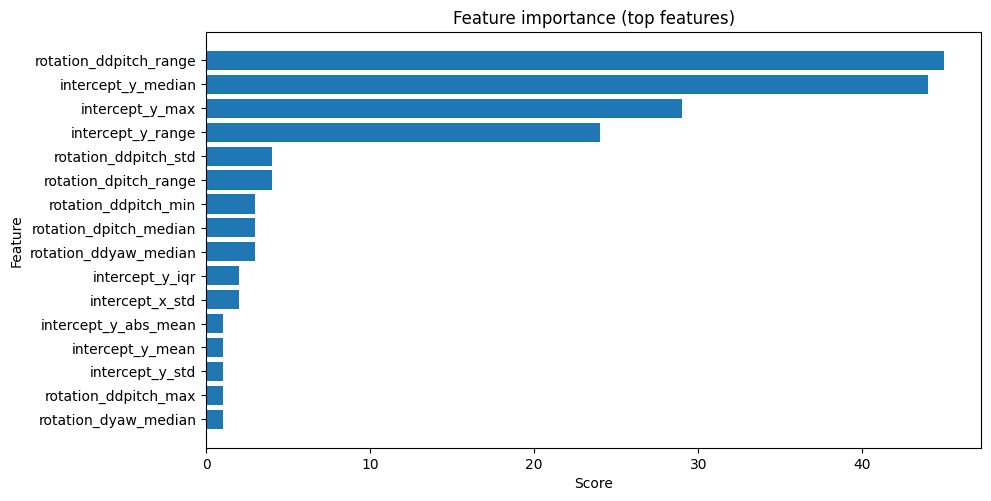

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get importance dictionary from the trained booster
importance_dict = classifier.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'fscore': list(importance_dict.values())
})

importance_df['fscore'] = importance_df['fscore'].astype(float)
importance_df = importance_df.sort_values(by='fscore', ascending=True)

# Plot the feature importance graph
plt.figure(figsize=(10, len(feature_columns) * 0.1))
bars = plt.barh(
    importance_df['feature'],
    importance_df['fscore']
)

# You will see that some features are very dominant especially on the Y-axis.
# This makes sense as there is generally more difference between how aimbots and humans aim on this axis.
# Due to the nature of aiming, humans and aimbots both require more horizontal movement, leading to more variation and crossover between the two.
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature importance (top features)')
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 2.0, 3.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_df, y_series)

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best params: {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.3}
Best score: 0.9848484848484848


In [12]:
import joblib

# We need to save our model AND the scaler (so we can load our model and apply the exact same scaling live)
joblib.dump(classifier, "visient_model.pkl")
joblib.dump(scaler, "visient_scaler.pkl")

['visient_scaler.pkl']

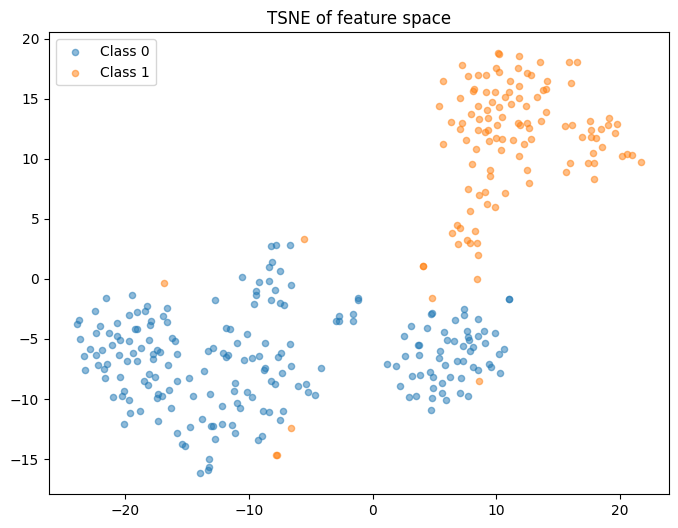

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# TSNE is important so we can visualize the separation between clusters in our profile.
# We can see our data has strong clustering, which can mean a few things.
# First, it means our model did a great job classifying human and aimbots!
# It can also mean that the dataset is too weak, and that we need more diverse data from both classes to really push the model to its limit.
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    max_iter=1000
)

X_embedded = tsne.fit_transform(X_df)

# Plot
plt.figure(figsize=(8, 6))

for label in np.unique(y_series):
    mask = y_series == label
    plt.scatter(
        X_embedded[mask, 0],
        X_embedded[mask, 1],
        label=f"Class {label}",
        alpha=0.5,
        s=20
    )

plt.legend()
plt.title("TSNE of feature space")
plt.show()
